# Exercise 4: Neural Networks Learning

In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.


## Our dataset

We are given a data set in `ex4data1.mat` that contains 5000 training examples of handwritten digits. (This is exactly the same data set as in last week's exercise 3).

Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. Like in the last exercise, a “0” digit is labeled as “10”, while the digits “1” to “9” are labeled as “1” to “9” in their natural order.



In [1]:
% Load saved matrices for X and y from file
load('data/ex4data1.mat');
% The matrices X and y will now be in our Octave environment

Our neural network is shown in the picture below. It has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20 × 20, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1).

![Structure fo our Neural Network](network_structure.png)

We will begin by visualizing a subset of the training set. We reuse the 'displayDat'a function from the last exercise.

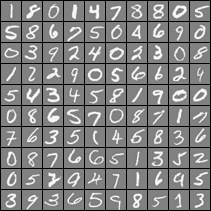

In [2]:
m = size(X, 1);

% Randomly select 100 data points 
rand_indices = randperm(m);
sel = X(rand_indices(1:100), :);
% and display them
displayData(sel);


In order to get started, we have been provided with a set of network parameters $ (\Theta^{(1)},\Theta^{(2)}) $ that have neen previously trained. These are stored in ex4weights.mat. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [3]:
% Load trained parameters as matrices Theta1 and Theta2 
load('data/ex4weights.mat');
% Theta1 has size 25 x 401
% Theta2 has size 10 x 26

In [4]:
%% Setup the parameters you will use for this exercise
input_layer_size  = 400;  % 20x20 Input Images of Digits
hidden_layer_size = 25;   % 25 hidden units
num_labels = 10;          % 10 labels, from 1 to 10   
                          % (note that we have mapped "0" to label 10)

## Forward propagation and cost function

As a first step, we will implement the cost function and the gradient for the neural network. The cost function (without regularization) is defined as:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K}[-y_k^{(i)} \log(h_\theta(x^{(i)})_k) - (1-y_k^{(i)}) \log(1 - h_\theta(x^{(i)})_k) ] $$ 

where $ K $ is the number of labels (or outputs, in our case $ K = 10$ and $ h_\theta(x^{(i)})_k = a^{(3)}_k $ is the activation value of the $k$th unit in the output layer (compare with neural network layout depicted above).

As always we make use of a couple of helper functions.

In [5]:
function g = sigmoid(z)
%SIGMOID Compute sigmoid function
%   g = SIGMOID(z) computes the sigmoid of z.

    % The function should work on scalar *and* matrix values 
    g = zeros(size(z));
    
    g = 1 ./ ( 1 + exp(-z));
end

In [6]:
function g = sigmoidGradient(z)
%SIGMOIDGRADIENT returns the gradient of the sigmoid function
%evaluated at z
%   g = SIGMOIDGRADIENT(z) computes the gradient of the sigmoid function
%   evaluated at z. t.

    % The function should work on scalar *and* matrix values
    g = zeros(size(z));

    g = sigmoid(z) .* (1-sigmoid(z));
end


In [7]:
fprintf('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ');
g = sigmoidGradient([-1 -0.5 0 0.5 1])

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
g =

   0.19661   0.23500   0.25000   0.23500   0.19661

  


In [8]:
function result = h(theta, x)
    result = (sigmoid(theta' * x'))';
end

### Step 1: Feedforward computation 

As a first step we implement the feedforward computation that computes $ h_\theta(x^{(i)}) $ for every example $ i $ and sums the cost over all examples. 



### Step 2: Backpropagation

As a second step, we will implement the backpropagation algorithm to compute the gradients 
$ \frac{\partial}{\partial \theta_{ij}^{(l)}} J(\Theta) $ of our cost function. 

Recall that the intuition behind the backpropagation algorithm is as follows. Given a
training example $ (x^{(t)}, y^{(t)}) $, we will first run a “forward pass” to compute
all the activations throughout the network, including the output value of the
hypothesis $ h_\theta (x{(t}) $. 

Then, for each node j in layer l, we would like to compute
an “error term” $ \delta_j(l) $ that measures how much that node was “responsible” 
for any errors in our output.

* For an output node, we can directly measure the difference between the
network’s activation and the true target value, and use that to define $ \delta_j^{(3)} $
(since layer 3 is the output layer):

$$ \delta_j^{(3)} = \alpha_j^{(3)} - y_j $$

* For the hidden units, we can compute $ δ_{j}(l) $ based on a weighted average of the error terms 
$ \delta^{(l+1)} $ of the nodes in layer $ (l + 1) $:

$$ \delta^{(l)} = {\Theta^{(l)}}^T \delta_{(l+1)} .* g'(z^{(l)}) $$

Why? Let's assume a very simple, *linear* neural network. $ \delta^{(l)} $ can be seen as the change of the network's cost function $ J $ in relation to a change in the output $ z^{(l)} $ of our node in layer $ l $.

$$ 
\begin{align}
\delta^{(l)} & = \frac{\partial}{\partial z^{(l)}} J(\theta^{l}) \\
    & = \frac{\partial J(\theta^{l})}{\partial z^{(l)}} \frac{\partial z^{(l+1)}}{\partial z^{(l+1)}} 
    = \underbrace{\frac{\partial J(\theta^{l})}{\partial z^{(l+1)}}}_{= \delta^{(l+1)}} \underbrace{\frac{\partial z^{(l+1)}}{\partial z^{(l)}}}_{=(*)} \\
\end{align}
$$

Let's calculate (*):

$$
\begin{align}
\frac{\partial z^{(l+1)}}{\partial z^{(l)}} & \overbrace{=}^{k:=l+1} \frac{\partial z^{(k)}}{\partial z^{(k-1)}} 
     = \frac{\partial}{\partial z^{(k-1)}}(\theta^{(k-1)} g(z^{(k-1)})) 
     = \theta^{(k-1)} g'(z^{(k-1)}) \\
     & \overbrace{=}^{l=k-1} = \theta^{(l)} g'(z^{(l)}) \\ 
\end{align}
$$

Put together:

$$ \delta^{(l)} = \delta^{(l+1)} \theta^{(l)} g'(z^{(l)}) $$

Recall, recall that 

$$ g'(z^{(l)}) = g(z^{(l)})(1-g(z^{(l)})) = \alpha^{l}(1-\alpha^{(l)}) $$ 

With

$$ \Delta^{(l)} = \delta^{(l+1)} (\alpha^{(l)})^T $$

we can compute our gradients as follows:

$$ \frac{\partial}{\partial \theta_{ij}^{(l)}} J(\Theta) = \frac{1}{m} \Delta_{ij}^{(l)} $$ 

### Step 3: Regularized cost function

For neural networks *with regularization* we add a regularization term to the cost function.

$$ r = \frac{\lambda}{m} ( \sum_{\Theta^{(1)}_{j \neq 1, i \neq 1}} (\Theta^{1}_{j, i})^2 ) +  \sum_{\Theta^{(2)}_{j \neq 1, i \neq 1}} (\Theta^{2}_{j, i})^2 $$

Note that you should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix.

In [9]:
function [J grad] = nnCostFunction(nn_params, ...
                                   input_layer_size, ...
                                   hidden_layer_size, ...
                                   num_labels, ...
                                   X, y, lambda)
%NNCOSTFUNCTION Implements the neural network cost function for a two layer
%neural network which performs classification
%   [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
%   X, y, lambda) computes the cost and gradient of the neural network. The
%   parameters for the neural network are "unrolled" into the vector
%   nn_params and need to be converted back into the weight matrices. 
% 
%   The returned parameter grad should be a "unrolled" vector of the
%   partial derivatives of the neural network.
%

    % Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    % for our 2 layer neural network
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                 hidden_layer_size, (input_layer_size + 1));

    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                 num_labels, (hidden_layer_size + 1));

    % dim_Theta1 = size(Theta1)
    % dim_Theta2 = size(Theta2)
    
    % Setup some useful variables
    m = size(X, 1)
         
    % We need to return the following variables correctly 
    J = 0;
    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));

    % Part 1: Feedforward the neural network and return the cost in the
    %         variable J. 
    
    % Add additional bias node to X
    X = [ones(m, 1) X];
    
    % Note, that whereas the original labels (in the variable y) were 1, 2, ..., 10, 
    % for the purpose of training a neural network, 
    % we need to recode the labels as vectors containing only values 0 or 1. 
    y_Vec = zeros(m, num_labels);
    for i =1:m
        y_Vec(i, y(i)) = 1;
    end

    % Theta1, Theta2 need to be transposed, since h(theta, X) expects theta to be a column vector
    % In Theta1, Theta2 however, the parameters for each node are represented as a row

    % Hidden layer
    alpha2 = h(Theta1', X);
    
    % Add additional bias node alpha2(0)
    alpha2 = [ones(m, 1) alpha2];
    
    % Output layer
    alpha3 = h(Theta2', alpha2);
    
    % Cost function without regularization term

    % We can use matrix multiplication to compute our inner sum
    inner = -log(alpha3)*y_Vec' - log(1-alpha3)*(1-y_Vec') ;
    sum1 = sum(diag(inner));
    
    J = 1/m * sum1; 


    % Part 2: Implement the backpropagation algorithm to compute the gradients
    %         Theta1_grad and Theta2_grad. You should return the partial derivatives of
    %         the cost function with respect to Theta1 and Theta2 in Theta1_grad and
    %         Theta2_grad, respectively. 

    % Output layer
    delta3 = alpha3 - y_Vec;
    
    % Hidden layer
    delta2 = delta3 * Theta2 .* alpha2 .* (1-alpha2);
    delta2 = delta2(:, 2:end);
    
    Delta1 = delta2' * X;
    Delta2 = delta3' * alpha2;
    
    Theta1_grad = 1/m * Delta1;
    Theta2_grad = 1/m * Delta2;

    %
    % Part 3: Implement regularization with the cost function and gradients.
    %    
    
    % Regularization term for the cost function
    Theta1_squared = Theta1 .^ 2;
    Theta2_squared = Theta2 .^ 2;
    
    Theta1_squared = Theta1_squared(:, 2:end);
    Theta2_squared = Theta2_squared(:, 2:end);
    
    reg_sum = sum(Theta1_squared(:)) + sum(Theta2_squared(:));
    J = J + lambda /(2*m) * reg_sum;

    % Regularization terms for the gradient matrices
    R1 = Theta1;
    R1(:, 1) = 0;
    R2 = Theta2;
    R2(:, 1) = 0;

    Theta1_grad = Theta1_grad + lambda/m * R1;
    Theta2_grad = Theta2_grad + lambda/m * R2;
    
    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];

end

In [10]:
% Addional testcase
il = 2;              % input layer
hl = 2;              % hidden layer
nl = 4;              % number of labels
nn = [ 1:18 ] / 10;  % nn_params
X_test = cos([1 2 ; 3 4 ; 5 6]);
y_test = [4; 2; 3];
[J grad] = nnCostFunction(nn, il, hl, nl, X_test, y_test, 0)
[J grad] = nnCostFunction(nn, il, hl, nl, X_test, y_test, 4)

m =  3
J =  7.4070
grad =

   0.766138
   0.979897
  -0.027540
  -0.035844
  -0.024929
  -0.053862
   0.883417
   0.568762
   0.584668
   0.598139
   0.459314
   0.344618
   0.256313
   0.311885
   0.478337
   0.368920
   0.259771
   0.322331

m =  3
J =  19.474
grad =

   0.76614
   0.97990
   0.37246
   0.49749
   0.64174
   0.74614
   0.88342
   0.56876
   0.58467
   0.59814
   1.92598
   1.94462
   1.98965
   2.17855
   2.47834
   2.50225
   2.52644
   2.72233



In [11]:
% Unroll parameters 
nn_params = [Theta1(:) ; Theta2(:)];

% Call cost function
% without regularization:
lambda = 0;
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, ...
                   num_labels, X, y, lambda);

fprintf(['Cost at parameters (loaded from ex4weights): %f '...
         '\n(this value should be about 0.287629)\n'], J);
         
% with regularization (lambda = 1):
lambda = 1;
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, ...
                   num_labels, X, y, lambda);

fprintf(['Cost at parameters (loaded from ex4weights) with regularization (lambda=1): %f '...
         '\n(this value should be about 0.383770)\n'], J);

m =  5000
Cost at parameters (loaded from ex4weights): 0.287629 
(this value should be about 0.287629)
m =  5000
Cost at parameters (loaded from ex4weights) with regularization (lambda=1): 0.383770 
(this value should be about 0.383770)


## Gradient Checking

We can apply a method called *gradient checking* to verify numerically, if the computation of the gradients through backpropagation was correct. 

The idea ist to "onroll" $ \Theta^{(1)}, \Theta^{(2)} $ into a long vector $ \theta $ and work with a function $ J{\theta) $.

We can now verify if our "onrolled" gradient $ f_i(\theta) $ computed above matches a numerical approximation of the gradient for each $ i $:

$$ f_i(\theta) = \frac {J(\theta^{(i+)}) - J(\theta^{(i-)}) } {2 \epsilon} $$

$ \theta^{(i+)} $ is the same as $ \theta $, except its $i$th element has been incremented by $ \epsilon $. Similarly, $ \theta^{(i-)} $ is the corresponding vector with the $i$th element decreased by $ \epsilon $.


In [12]:
function W = debugInitializeWeights(fan_out, fan_in)
%DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
%incoming connections and fan_out outgoing connections using a fixed
%strategy, this will help you later in debugging
%   W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
%   of a layer with fan_in incoming connections and fan_out outgoing 
%   connections using a fix set of values
%
%   Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
%   the first row of W handles the "bias" terms
%

    % Set W to zeros
    W = zeros(fan_out, 1 + fan_in);

    % Initialize W using "sin", this ensures that W is always of the same
    % values and will be useful for debugging
    W = reshape(sin(1:numel(W)), size(W)) / 10;
end

In [13]:
function numgrad = computeNumericalGradient(J, theta)
%COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
%and gives us a numerical estimate of the gradient.
%   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
%   gradient of the function J around theta. Calling y = J(theta) should
%   return the function value at theta.

% Notes: The following code implements numerical gradient checking, and 
%        returns the numerical gradient.It sets numgrad(i) to (a numerical 
%        approximation of) the partial derivative of J with respect to the 
%        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
%        be the (approximately) the partial derivative of J with respect 
%        to theta(i).)
%                

    numgrad = zeros(size(theta));
    perturb = zeros(size(theta));
    e = 1e-4;
    for p = 1:numel(theta)
        % Set perturbation vector
        perturb(p) = e;
        loss1 = J(theta - perturb);
        loss2 = J(theta + perturb);
        % Compute Numerical Gradient
        numgrad(p) = (loss2 - loss1) / (2*e);
        perturb(p) = 0;
    end

end

In [14]:
function checkNNGradients(lambda)
%CHECKNNGRADIENTS Creates a small neural network to check the
%backpropagation gradients
%   CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
%   backpropagation gradients, it will output the analytical gradients
%   produced by your backprop code and the numerical gradients (computed
%   using computeNumericalGradient). These two gradient computations should
%   result in very similar values.
%

    if ~exist('lambda', 'var') || isempty(lambda)
        lambda = 0;
    end

    input_layer_size = 3;
    hidden_layer_size = 5;
    num_labels = 3;
    m = 5;

    % We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size);
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size);
    % Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1);
    y  = 1 + mod(1:m, num_labels)';

    % Unroll parameters
    nn_params = [Theta1(:) ; Theta2(:)];

    % Short hand for cost function
    costFunc = @(p) nnCostFunction(p, input_layer_size, hidden_layer_size, ...
                               num_labels, X, y, lambda);

    [cost, grad] = costFunc(nn_params);
    numgrad = computeNumericalGradient(costFunc, nn_params);

    % Visually examine the two gradient computations.  The two columns
    % you get should be very similar. 
    disp([numgrad grad]);
    fprintf(['The above two columns you get should be very similar.\n' ...
         '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n']);

    % Evaluate the norm of the difference between two solutions.  
    % If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    % in computeNumericalGradient.m, then diff below should be less than 1e-9
    diff = norm(numgrad-grad)/norm(numgrad+grad);

    fprintf(['If your backpropagation implementation is correct, then \n' ...
         'the relative difference will be small (less than 1e-9). \n' ...
         '\nRelative Difference: %g\n'], diff);

end

In [15]:
checkNNGradients(0);

m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
m =  5
  -0.0092782523  -0.0092782524
   0.0088991196   0.0088991196
  -0.0083601076  -0.0083601076
   0.0076281355   0.0076281355
  -0.0067479837  -0.0067479837
  -0.0000030498  -0.0000030498
   0.0000142869   0.0000142869
  -0.0000259383  -0.0000259383
   0.0000369883   0.0000369883
  -0.0000468760  -0.0000468760
  -0.0001750601  -0.0001750601
   0.0002331464   0.0002331464
  -0.0002874687  -0.0002874687
   0.0003353203   0.0003353203
  -0.0003762156  -0.0003762

## Training

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $ \Theta^{(l)} $ uniformly in the range $ [-\epsilon, +\epsilon] $.

The training done again by using the well know optimization function:

In [16]:
function W = randInitializeWeights(L_in, L_out)
%RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
%incoming connections and L_out outgoing connections
%   W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
%   of a layer with L_in incoming connections and L_out outgoing 
%   connections. 
%
%   Note that W should be set to a matrix of size(L_out, 1 + L_in) as
%   the first column of W handles the "bias" terms
%
    
    W = zeros(L_out, 1 + L_in);
    
    % Randomly initialize the weights to small values
    eps = 0.12;
    W = rand(L_out, 1 + L_in) * 2 * eps - eps;

end

In [17]:
%  After you have completed the assignment, change the MaxIter to a larger
%  value to see how more training helps.
options = optimset('MaxIter', 50);

%  You should also try different values of lambda
lambda = 1;

% Initial parameters
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels);

% Unroll parameters
initial_nn_params = [initial_Theta1(:) ; initial_Theta2(:)];

% Create "short hand" for the cost function to be minimized
costFunction = @(p) nnCostFunction(p, ...
                                   input_layer_size, ...
                                   hidden_layer_size, ...
                                   num_labels, X, y, lambda);

% Now, costFunction is a function that takes in only one argument (the
% neural network parameters)
[nn_params, cost] = fmincg(costFunction, initial_nn_params, options);

% Obtain Theta1 and Theta2 back from nn_params
Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                 hidden_layer_size, (input_layer_size + 1));

Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                 num_labels, (hidden_layer_size + 1));

m =  5000
m =  5000
m =  5000
m =  5000
m =  5000     1 | Cost: 3.313755e+00
m =  5000
m =  5000
m =  5000
m =  5000     2 | Cost: 3.247555e+00
m =  5000
m =  5000     3 | Cost: 3.230282e+00
m =  5000
m =  5000
m =  5000
m =  5000     4 | Cost: 2.811384e+00
m =  5000     5 | Cost: 2.531807e+00
m =  5000     6 | Cost: 2.191695e+00
m =  5000
m =  5000     7 | Cost: 2.060271e+00
m =  5000     8 | Cost: 1.936586e+00
m =  5000     9 | Cost: 1.770072e+00
m =  5000
m =  5000    10 | Cost: 1.715002e+00
m =  5000
m =  5000    11 | Cost: 1.579801e+00
m =  5000    12 | Cost: 1.348370e+00
m =  5000
m =  5000    13 | Cost: 1.300078e+00
m =  5000    14 | Cost: 1.270104e+00
m =  5000    15 | Cost: 1.234539e+00
m =  5000    16 | Cost: 1.179599e+00
m =  5000    17 | Cost: 1.140101e+00
m =  5000    18 | Cost: 1.094471e+00
m =  5000    19 | Cost: 1.042942e+00
m =  5000    20 | Cost: 1.006912e+00
m =  5000    21 | Cost: 9.624815e-01
m =  5000    22 | Cost: 9.014425e-01
m =  5000
m =  5000    23 | Cost: 8.

## Results

Let's implement a function that uses the neural network defined by the parameters $ (\Theta^{(1)},\Theta^{(2)}) $ to predict the digits for a given data set of our training data:

In [18]:
function p = predict(Theta1, Theta2, X)
%PREDICT Predict the label of an input given a trained neural network
%   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
%   trained weights of a neural network (Theta1, Theta2)

    % Useful values
    m = size(X, 1);
    num_labels = size(Theta2, 1);

    p = zeros(size(X, 1), 1);
    
    % Add ones to the X data matrix
    X = [ones(m, 1) X];

    % Theta1, Theta2 need to be transposed, since h(theta, X) expects theta to be a column vector
    % In Theta1, Theta2 however, the parameters for each node are represented as a row

    % Hidden layer
    alpha2 = h(Theta1', X);
    
    % Add additional bias node alpha2(0)
    alpha2 = [ones(m, 1) alpha2];
    
    % Output layer
    alpha3 = h(Theta2', alpha2);
    
    % Pick the best output und use it as label
    [M, p] = max(alpha3, [], 2);

end

In [19]:
pred = predict(Theta1, Theta2, X);

fprintf('\nTraining Set Accuracy: %f\n', mean(double(pred == y)) * 100);


Training Set Accuracy: 94.920000


Let's see what our trained logistic regression function is doing for our randomly selected examples from the beginning of this exercise:

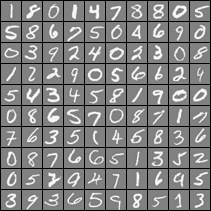

In [20]:
displayData(sel);

In [21]:
% Predict the labels for the selection and convert label 10 to 0
guessed_numbers = mod(predict(Theta1, Theta2, sel), 10);

In [22]:
% ... and print them as a matrix 
reshape(guessed_numbers, [10,10])'

ans =

   1   8   0   1   4   7   8   8   0   5
   5   8   6   7   5   0   4   6   9   0
   0   3   9   2   4   0   2   3   0   8
   1   2   2   9   0   5   6   6   2   4
   5   4   3   4   5   8   1   9   0   0
   0   8   6   5   7   0   8   7   1   0
   7   6   3   5   5   4   5   8   3   6
   0   8   7   6   6   5   1   3   5   2
   0   5   2   9   4   7   1   6   9   5
   3   9   3   6   5   9   8   5   1   3

